In [2]:
#Use pytorch for the Neural Network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import tqdm
import wandb #for MLOps Logging
import optuna

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
#Random seed
torch.manual_seed(42)
if torch.cuda.is_available():
    print("Cuda is available")
    torch.cuda.manual_seed_all(42)  # For all GPUs

Cuda is available


In [16]:
print(torch.__version__)
print(torch.version.cuda)

2.1.0+cu121
12.1


# Load Dataset

### Processed from the previous homework (change csv format from ';' delimited, to ',')

In [3]:
#Load the Dataset, 
originalTrain = pd.read_csv('Data/adult/adult_processed.data', header=None)
originalTest = pd.read_csv('Data/adult/adult_processed.test', header=None, skiprows=1)
CSVcolumnNaming = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
                       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
                       'hours-per-week', 'native-country', 'income']
originalTrain.columns = CSVcolumnNaming
originalTest.columns = CSVcolumnNaming
#adultsTest is labelled, and I will use it as a test set (not included in training)
originalTest.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


# Exploratory Data Analysis

### To avoid reduplicate program, I will just state the conclusion for the data, in AdultDataset_DecisionTree.ipynb

### Conclusion
- Train and Test set all have similar value distributions on all attributes
- There is imbalance in target variable, consider using weighted class when doing weight update
- Highly correlated variables like education and education-num can be selected one, I might select education-num due to sklearn decision tree is better with continuous variable


- There is missing value on 'workclass', 'occupation', 'native-country'. Last time on decision tree we have a good result on using "mode" rather than dropping all the missing value samples, I will use this also for both the train and test dataset. 
- Some notes on variables that place high height on last time (from the decision tree):
    - marital-status (Top node)
    - capital-gain
    - education-num
    - capital-loss
- Neural Network might be badly influenced by duplicate feature and high cardinality features (as they need to be employed with one hot encoding). With that consideration in mind, there are some variables we need to pay attention:
    - education and education-num: This two variables are almost identical proven from the DecisionTree.ipynb, I will use education-num only
    - we have a lot of nations variables (40 possible values), we will group them to continent to reduce cardinality
    - Last time on decision tree, we group marital-status of "Divorced", "Widowed", "Separated", which can simply has similar distribution and meaning (along with the distribution), simply means that they are a spouse but currently alone. I will try two approach that uses this grouping and the one not

- Neural Network is greatly affected by skewed variables, We need to check the skewness of the continuous variables. From the drawing in EDA Graph in DecisionTree ipynb, we have a lot of variables are skewed, to be more concrete I will use the .skew() method evaluation

In [18]:
continuous_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
skewness = originalTrain[continuous_columns].skew()

print(skewness)

age                0.558743
fnlwgt             1.446980
education-num     -0.311676
capital-gain      11.953848
capital-loss       4.594629
hours-per-week     0.227643
dtype: float64


- Meaning of the skew:
    - positive value: positive skew
    - negative value: Negative skew
    - abs(0-0.5): Not skewed
    - abs(0.5 - 1.0): moderately skewed
    - abs(>1.0): Highly skewed
- The fnlwgt, capital-gain, capital-loss are badly skewed, we will consider to do trial to fix this skew in the future, whether it will make the result better

# Modelling

Goal: Balanced Accuracy, to handle class Imbalanced

In [19]:
def apply_one_hot_encoding(df_train, df_test, column_name):
    encoder = OneHotEncoder(sparse=False, drop='first')

    encoded_data = encoder.fit_transform(df_train[[column_name]])
    encoded_data_test = encoder.transform(df_test[[column_name]])

    new_column_names = [f"{column_name}_{value}" for value in encoder.categories_[0][1:]]

    encoded_df = pd.DataFrame(encoded_data, columns=new_column_names)
    encoded_df_test = pd.DataFrame(encoded_data_test, columns=new_column_names)

    df_train = df_train.drop(column_name, axis=1).reset_index(drop=True)
    df_test = df_test.drop(column_name, axis=1).reset_index(drop=True)

    df_train = pd.concat([df_train, encoded_df], axis=1)
    df_test = pd.concat([df_test, encoded_df_test], axis=1)

    return df_train, df_test

In [20]:
#Also use balanced accuracy
def scoringCalculations(dtree, Xdata, Ydata, model_name, context, n_splits=10):
    # since class is imbalanced, we use macro average
    y_pred = dtree.predict(Xdata)
    stratified_kfold = StratifiedKFold(n_splits=n_splits)
    print("====================================")
    if(context == "train"):
        cross_val_score_list = cross_val_score(dtree, Xdata, Ydata, cv=stratified_kfold, scoring='balanced_accuracy')
        print(f"{model_name}'s crossval(balanced_accuracy) score: {cross_val_score_list.mean()}, with values: {cross_val_score_list}")
    print(f"{model_name}'s {context} balanced accuracy: {balanced_accuracy_score(Ydata, y_pred)}")
    print(f"{model_name}'s {context} accuracy: {accuracy_score(Ydata, y_pred)}")
    print(f"{model_name}'s {context} precision: {precision_score(Ydata, y_pred, average='macro')}")
    print(f"{model_name}'s {context} recall: {recall_score(Ydata, y_pred, average='macro')}")
    print(f"{model_name}'s {context} f1 score: {f1_score(Ydata, y_pred, average='macro')}")
    print(f"{model_name}'s {context} confusion matrix: ")
    print(confusion_matrix(Ydata, y_pred))
    print("=====================================")

In [21]:
model_name='allSameAnswer'
all1 = originalTrain['income'].copy()
for i in range(len(all1)):
    all1[i] = "<=50K"
all1_test = originalTest['income'].copy()
for i in range(len(all1_test)):
    all1_test[i] = "<=50K"
print("====================================")
print(f"{model_name}'s balanced accuracy: {balanced_accuracy_score(originalTrain['income'],all1)}")
print(f"{model_name}'s accuracy: {accuracy_score(originalTrain['income'],all1)}")
print(f"{model_name}'s precision: {precision_score(originalTrain['income'], all1, average='macro')}")
print(f"{model_name}'s recall: {recall_score(originalTrain['income'], all1, average='macro')}")
print(f"{model_name}'s f1 score: {f1_score(originalTrain['income'], all1, average='macro')}")
print(f"{model_name}'s confusion matrix: ")
print(confusion_matrix(originalTrain['income'], all1))
print("=====================================")
print(f"{model_name}'s balanced accuracy: {balanced_accuracy_score(originalTest['income'],all1_test)}")
print(f"{model_name}'s accuracy: {accuracy_score(originalTest['income'],all1_test)}")
print(f"{model_name}'s precision: {precision_score(originalTest['income'], all1_test, average='macro')}")
print(f"{model_name}'s recall: {recall_score(originalTest['income'], all1_test, average='macro')}")
print(f"{model_name}'s f1 score: {f1_score(originalTest['income'], all1_test, average='macro')}")
print(f"{model_name}'s confusion matrix: ")
print(confusion_matrix(originalTest['income'], all1_test))

allSameAnswer's balanced accuracy: 0.5
allSameAnswer's accuracy: 0.7591904425539756


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


allSameAnswer's precision: 0.3795952212769878
allSameAnswer's recall: 0.5
allSameAnswer's f1 score: 0.43155671164958714
allSameAnswer's confusion matrix: 
[[24720     0]
 [ 7841     0]]
allSameAnswer's balanced accuracy: 0.5
allSameAnswer's accuracy: 0.7637737239727289
allSameAnswer's precision: 0.38188686198636446
allSameAnswer's recall: 0.5
allSameAnswer's f1 score: 0.4330338487254492
allSameAnswer's confusion matrix: 
[[12435     0]
 [ 3846     0]]


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
def DataPreparationPipeline(train_data, test_data, choices = {}):
    train_data_copy = train_data.copy()
    test_data_copy = test_data.copy()

    if(choices.get('handle_missing_value', None)):
        train_data_copy['workclass'].replace('?', train_data_copy['workclass'].mode()[0], inplace=True)
        train_data_copy['occupation'].replace('?', train_data_copy['occupation'].mode()[0], inplace=True)
        train_data_copy['native-country'].replace('?', train_data_copy['native-country'].mode()[0], inplace=True)
        test_data_copy['workclass'].replace('?', test_data_copy['workclass'].mode()[0], inplace=True)
        test_data_copy['occupation'].replace('?', test_data_copy['occupation'].mode()[0], inplace=True)
        test_data_copy['native-country'].replace('?', test_data_copy['native-country'].mode()[0], inplace=True)
    else:
        train_data_copy['workclass'].replace('?', train_data_copy['workclass'].mode()[0], inplace=True)
        train_data_copy['occupation'].replace('?', train_data_copy['occupation'].mode()[0], inplace=True)
        train_data_copy['native-country'].replace('?', train_data_copy['native-country'].mode()[0], inplace=True)
        test_data_copy['workclass'].replace('?', test_data_copy['workclass'].mode()[0], inplace=True)
        test_data_copy['occupation'].replace('?', test_data_copy['occupation'].mode()[0], inplace=True)
        test_data_copy['native-country'].replace('?', test_data_copy['native-country'].mode()[0], inplace=True)

    #since we have education similar to that of education-num
    train_data_copy.drop(['education'], axis=1, inplace=True)
    test_data_copy.drop(['education'], axis=1, inplace=True)

    #Reduce Cardinality in native-country
    countryGrouping = {
        "North-America": ["United-States", "Canada"],
        "Asia": ["China", "India", "Japan", "Iran", "Philippines", "Vietnam", "Taiwan", "Hong", "Thailand", "Cambodia", "Laos", "South"],
        "Europe": ["Germany", "England", "Italy", "Poland", "France", "Greece", "Ireland", "Scotland", "Yugoslavia", "Hungary", "Portugal", "Holand-Netherlands"],
        "Africa":[ "Cuba", "Jamaica", "Mexico", "Puerto-Rico", "Honduras", "Columbia", "Ecuador", "Peru", "Nicaragua", "Dominican-Republic", "El-Salvador", "Guatemala", "Trinadad&Tobago", "Haiti", "Outlying-US(Guam-USVI-etc)"],
        "?": ["?"],
    }
    for country, group in countryGrouping.items():
        train_data_copy['native-country'] = train_data_copy['native-country'].replace(group, country)
        test_data_copy['native-country'] = test_data_copy['native-country'].replace(group, country)

    
    twovalued_categorical_variables = ['sex', 'income']
    for column in twovalued_categorical_variables:
        label_encoder = LabelEncoder()
        train_data_copy[column] = label_encoder.fit_transform(train_data_copy[column])
        test_data_copy[column] = label_encoder.transform(test_data_copy[column])
        
        label_mapping = {original: encoded for encoded, original in enumerate(label_encoder.classes_)}
        print(f"{column}: ", label_mapping)
    label_mapping = {original: encoded for encoded, original in enumerate(label_encoder.classes_)}
    print(f"{column}: ", label_mapping)

    multivalued_categorical_variables = ['workclass', 'marital-status', 'occupation', 'relationship', 'native-country', 'race']
    for column in multivalued_categorical_variables:
        train_data_copy, test_data_copy = apply_one_hot_encoding(train_data_copy, test_data_copy, column)

    if(choices.get('SMOTE', None)):
        # SMOTE should only be applied on the training set
        smote = SMOTE(random_state=42)
        X_train, y_train = train_data_copy.drop('income', axis=1), train_data_copy['income']
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        # Merge the SMOTEd data back into a dataframe
        train_data_copy = pd.DataFrame(X_train_smote, columns=X_train_smote.columns)
        train_data_copy['income'] = y_train_smote

    numerical_variables = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
    scaler = RobustScaler()
    train_data_copy[numerical_variables] = scaler.fit_transform(train_data_copy[numerical_variables])
    test_data_copy[numerical_variables] = scaler.transform(test_data_copy[numerical_variables])

    #apply PCAAC
    if choices.get('PCA_trials', None):
        pca = PCA()
        X_train_pca = pca.fit_transform(train_data_copy.drop('income', axis=1))

        # Explained variance ratio for each component
        explained_variance = pca.explained_variance_ratio_

        # Cumulative explained variance
        cumulative_explained_variance = np.cumsum(explained_variance)

        # Plot the explained variance
        plt.figure(figsize=(8, 4))
        plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center',
                label='individual explained variance')
        plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid',
                label='cumulative explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal component index')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()
    elif choices.get('PCA_Percentage', None):
        raise NotImplementedError("PCA Percentage not implemented yet")

    return train_data_copy, test_data_copy

sex:  {'Female': 0, 'Male': 1}
income:  {'<=50K': 0, '>50K': 1}
income:  {'<=50K': 0, '>50K': 1}


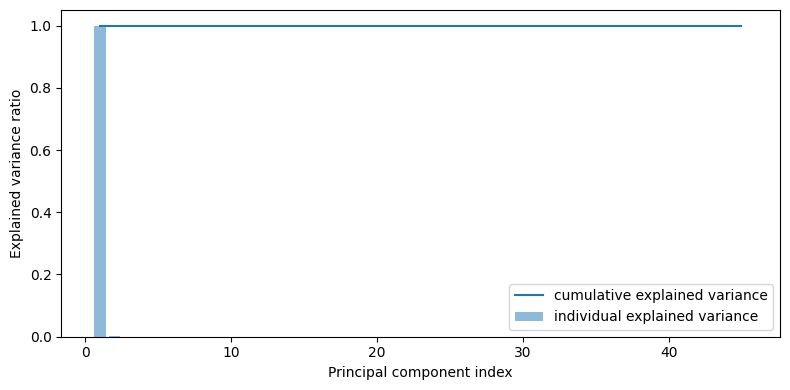

(        age    fnlwgt  education-num  sex  capital-gain  capital-loss  \
 0      0.10 -0.845803       1.000000    1        2174.0           0.0   
 1      0.65 -0.797197       1.000000    1           0.0           0.0   
 2      0.05  0.312773      -0.333333    1           0.0           0.0   
 3      0.80  0.472766      -1.000000    1           0.0           0.0   
 4     -0.45  1.342456       1.000000    0           0.0           0.0   
 ...     ...       ...            ...  ...           ...           ...   
 32556 -0.50  0.662165       0.666667    0           0.0           0.0   
 32557  0.15 -0.201151      -0.333333    1           0.0           0.0   
 32558  1.05 -0.221818      -0.333333    0           0.0           0.0   
 32559 -0.75  0.194038      -0.333333    1           0.0           0.0   
 32560  0.75  0.919035      -0.333333    0       15024.0           0.0   
 
        hours-per-week  income  workclass_Local-gov  workclass_Never-worked  \
 0                 0.0       0 

In [23]:
DataPreparationPipeline(originalTrain, originalTest, choices = {"PCA_trials": True})

## Make baseline Data
Start with the most baseline data

Most basic Data:
- Fill missing values with mode
- No skew fix
- Throw away education
- Group "nation" attribute
- Do not group "Divorced", "Widowed", "Separated" in marital-status
- Do one hot encoding for categorical variables with more than 2 values, otherwise use LabelEncoding
- RobustScaling on numeric variables
- No Dimension Reduction

In [24]:
train_data_basic, test_data_basic = DataPreparationPipeline(originalTrain, originalTest)

sex:  {'Female': 0, 'Male': 1}
income:  {'<=50K': 0, '>50K': 1}
income:  {'<=50K': 0, '>50K': 1}


In [25]:
train_data_smote, test_data_smote = DataPreparationPipeline(originalTrain, originalTest, choices={'SMOTE': True})

sex:  {'Female': 0, 'Male': 1}
income:  {'<=50K': 0, '>50K': 1}
income:  {'<=50K': 0, '>50K': 1}


### Go with the most baseline model: Logistic Regression

In [26]:
#LogisticRegression
lr = LogisticRegression(class_weight="auto", warm_start=True, max_iter=100)
lr.fit(train_data_basic.drop('income', axis=1), train_data_basic['income'])
scoringCalculations(lr, train_data_basic.drop('income', axis=1), train_data_basic['income'], "LogisticRegression", "train")
scoringCalculations(lr, test_data_basic.drop('income', axis=1), test_data_basic['income'], "LogisticRegression", "test")

C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

LogisticRegression's crossval(balanced_accuracy) score: 0.7476399535449576, with values: [0.74973023 0.7255713  0.76187587 0.7256167  0.74941591 0.74958721
 0.75832797 0.73249373 0.75115787 0.77262276]
LogisticRegression's train balanced accuracy: 0.7522441447515322
LogisticRegression's train accuracy: 0.843831577654249
LogisticRegression's train precision: 0.7965967365500726
LogisticRegression's train recall: 0.7522441447515322
LogisticRegression's train f1 score: 0.7699792250166588
LogisticRegression's train confusion matrix: 
[[22963  1757]
 [ 3328  4513]]
LogisticRegression's test balanced accuracy: 0.7494788500828332
LogisticRegression's test accuracy: 0.8446041397948529
LogisticRegression's test precision: 0.7947711760613756
LogisticRegression's test recall: 0.7494788500828332
LogisticRegression's test f1 score: 0.767568931776572
LogisticRegression's test confusion matrix: 
[[11562   873]
 [ 1657  2189]]


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Performance on train and test data similar, it means no overfit, won't apply optuna.
Balanced Accuracy falls greatly compared to Decision Tree (0.82), models is really biased

Current Iteration:  0
Current Iteration:  1
Current Iteration:  2


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  3
Current Iteration:  4
Current Iteration:  5


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  6
Current Iteration:  7
Current Iteration:  8


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  9
Current Iteration:  10
Current Iteration:  11


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  12
Current Iteration:  13
Current Iteration:  14


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  15
Current Iteration:  16
Current Iteration:  17


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  18
Current Iteration:  19
Current Iteration:  20
Current Iteration:  21
Current Iteration:  22


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  23
Current Iteration:  24
Current Iteration:  25


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  26
Current Iteration:  27
Current Iteration:  28


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  29
Current Iteration:  30
Current Iteration:  31


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  32
Current Iteration:  33
Current Iteration:  34


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  35
Current Iteration:  36
Current Iteration:  37


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  38
Current Iteration:  39
Current Iteration:  40


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  41
Current Iteration:  42
Current Iteration:  43


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  44
Current Iteration:  45
Current Iteration:  46


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  47
Current Iteration:  48
Current Iteration:  49


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  50
Current Iteration:  51
Current Iteration:  52


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  53
Current Iteration:  54
Current Iteration:  55


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  56
Current Iteration:  57
Current Iteration:  58


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  59
Current Iteration:  60
Current Iteration:  61


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  62
Current Iteration:  63
Current Iteration:  64


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  65
Current Iteration:  66
Current Iteration:  67


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  68
Current Iteration:  69
Current Iteration:  70


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  71
Current Iteration:  72
Current Iteration:  73


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  74
Current Iteration:  75
Current Iteration:  76


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  77
Current Iteration:  78
Current Iteration:  79


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  80
Current Iteration:  81
Current Iteration:  82


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  83
Current Iteration:  84


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  85
Current Iteration:  86
Current Iteration:  87


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  88
Current Iteration:  89
Current Iteration:  90


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  91
Current Iteration:  92


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  93
Current Iteration:  94
Current Iteration:  95
Current Iteration:  96


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Current Iteration:  97
Current Iteration:  98
Current Iteration:  99


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

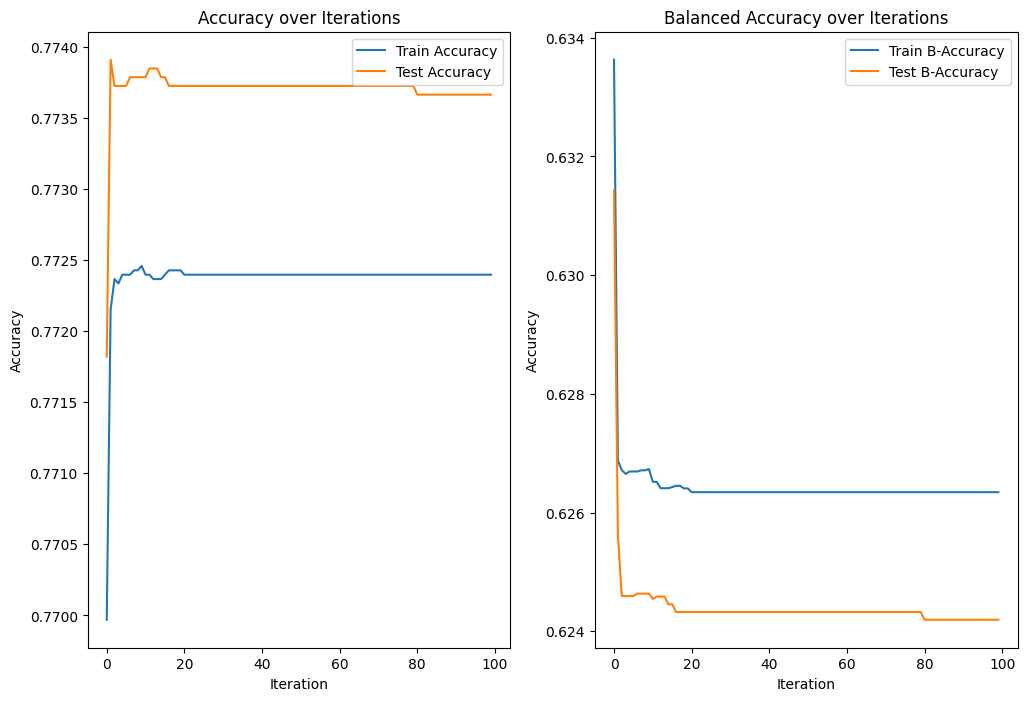

In [27]:
lr = LogisticRegression(warm_start=True, max_iter=1, class_weight="auto")

train_accuracies_every50 = []
test_accuracies_every50 = []
train_balanced_accuracies_every50 = []
test_balanced_accuracies_every50 = []

N_ITER = 100

for i in range(N_ITER):
    print("Current Iteration: ", i)
    lr.fit(train_data_basic.drop('income', axis=1), train_data_basic['income'])
    
    # Predict and calculate accuracy on training data
    train_pred = lr.predict(train_data_basic.drop('income', axis=1))
    train_accuracy = accuracy_score(train_data_basic['income'], train_pred)
    train_accuracies_every50.append(train_accuracy)
    train_balanced_accuracy = balanced_accuracy_score(train_data_basic['income'], train_pred)
    train_balanced_accuracies_every50.append(train_balanced_accuracy)
    
    # Predict and calculate accuracy on test data
    test_pred = lr.predict(test_data_basic.drop('income', axis=1))
    test_accuracy = accuracy_score(test_data_basic['income'], test_pred)
    test_accuracies_every50.append(test_accuracy)
    test_balanced_accuracy = balanced_accuracy_score(test_data_basic['income'], test_pred)
    test_balanced_accuracies_every50.append(test_balanced_accuracy)

# Plotting accuracies
fig, ax = plt.subplots(1,2, figsize=(12, 8))
ax[0].plot(train_accuracies_every50, label='Train Accuracy')
ax[0].plot(test_accuracies_every50, label='Test Accuracy')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy over Iterations')
ax[0].legend()

ax[1].plot(train_balanced_accuracies_every50, label='Train B-Accuracy')
ax[1].plot(test_balanced_accuracies_every50, label='Test B-Accuracy')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Balanced Accuracy over Iterations')
ax[1].legend()
fig.show()

stopping at 10, since models are quickly to get overfit

In [28]:
#LogisticRegression
lr = LogisticRegression(class_weight="auto", warm_start=True, max_iter=10)
lr.fit(train_data_basic.drop('income', axis=1), train_data_basic['income'])
scoringCalculations(lr, train_data_basic.drop('income', axis=1), train_data_basic['income'], "LogisticRegression", "train")
scoringCalculations(lr, test_data_basic.drop('income', axis=1), test_data_basic['income'], "LogisticRegression", "test")

C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

LogisticRegression's crossval(balanced_accuracy) score: 0.6263039412011171, with values: [0.62722234 0.6250516  0.61893617 0.62176788 0.62887813 0.63447758
 0.60691376 0.62559441 0.63068201 0.64351554]
LogisticRegression's train balanced accuracy: 0.6264116141854966
LogisticRegression's train accuracy: 0.7723657135837352
LogisticRegression's train precision: 0.6784181438191518
LogisticRegression's train recall: 0.6264116141854966
LogisticRegression's train f1 score: 0.6400627258312772
LogisticRegression's train confusion matrix: 
[[22445  2275]
 [ 5137  2704]]
LogisticRegression's test balanced accuracy: 0.6245863827315457
LogisticRegression's test accuracy: 0.7738468153061852
LogisticRegression's test precision: 0.6750133528807445
LogisticRegression's test recall: 0.6245863827315457
LogisticRegression's test f1 score: 0.6381128972318282
LogisticRegression's test confusion matrix: 
[[11285  1150]
 [ 2532  1314]]


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

### Training with More Superior Models, Neural Network

Randomly initialize to Input Layer x 6 x 6 x Output Layer (1)

In [46]:
# Define the neural network architecture
class BinaryClassificationModel(nn.Module):
    def __init__(self, input_dim=45, hidden_dims=[], dropout = []):
        super(BinaryClassificationModel, self).__init__()
        self.fc = []
        self.dropout = []
        self.dropout_applied = False
        layers = []
        prev_node_amt = input_dim
        for node_amt in hidden_dims:
            layers.append(nn.Linear(prev_node_amt, node_amt))
            prev_node_amt = node_amt
        layers.append(nn.Linear(prev_node_amt, 1))

        dropouts = []
        if(dropout != [] and dropout != None):
            assert len(dropout) == len(hidden_dims)
            self.dropout_applied = True
            for i in range(len(dropout)):
                dropouts.append(nn.Dropout(dropout[i]))
        for layer in self.fc:
            # Initialize weights using He initialization
            nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
        self.fc = nn.ModuleList(layers)
        self.dropout = nn.ModuleList(dropouts)
    def forward(self, x):
        for i in range(len(self.fc)-1):
            x = self.fc[i](x)
            x = F.relu(x)
            if(self.dropout_applied):
                x = self.dropout[i](x)
        for layer in self.fc[-1:]:
            x = torch.sigmoid(layer(x))

        return x

# Function to create dataloaders
def create_dataloaders(train_df, test_df, train_batch_size=None, num_workers = 2):
    X_train = train_df.drop(columns=["income"]).values
    y_train = train_df["income"]
    X_test = test_df.drop(columns=["income"]).values
    y_test = test_df["income"]

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

    # Create datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    if(not train_batch_size):
        train_batch_size = len(X_train)
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=len(X_test), shuffle=False, num_workers=num_workers)
    
    return train_loader, test_loader

def compute_accuracy(target, output):
    return accuracy_score(target.cpu(), output.float().round().cpu())

# Function to calculate balanced accuracy
def compute_balanced_accuracy(target, output):
    output = output.float().round().cpu().detach().numpy()
    target = target.cpu().detach().numpy()
    return balanced_accuracy_score(target, output)

def train_pipeline(train_df, test_df, training_choices = {}, model_name = "model", input_dim=45, hidden_dims=[], dropout = []):
    # Instantiate the model
    if(training_choices.get("device", None) != None):
        device = training_choices["device"]
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if(training_choices.get("num_workers", None) != None):
        num_workers = training_choices["num_workers"]
    else:
        num_workers = 2
    model = BinaryClassificationModel(input_dim=input_dim, hidden_dims=hidden_dims, dropout=dropout).to(device)

    if(training_choices.get("criterion", None) == "Weighted_BCE"):
        count_neg, count_pos = (train_df['income'] == 0).sum(), (train_df['income'] == 1).sum()
        print("Count_neg: ", count_neg)
        print("Count_pos: ", count_pos)
        # Calculate the weights for each class
        total_count = len(train_df)
        weight_neg = count_pos / total_count
        weight_pos = count_neg / total_count

        # Create a tensor of weights
        weights = torch.tensor([weight_neg, weight_pos],device=device)

        # Define the loss function with weights
        criterion = nn.BCEWithLogitsLoss(pos_weight=weights[1])
    else:
        criterion = nn.BCELoss()

    if(training_choices.get("weight_decay", None) != None):
        optimizer = optim.Adam(model.parameters(), weight_decay=training_choices["weight_decay"])
    else:
        optimizer = optim.Adam(model.parameters())

    # Define the number of epochs
    if(training_choices.get("n_epochs", None) != None):
        n_epochs = training_choices["n_epochs"]
    else:
        n_epochs = 100


    # Create dataloaders
    # Here 'target' is the name of your target column
    train_loader, test_loader = create_dataloaders(train_df, test_df, train_batch_size=training_choices.get("train_batch_size", None), num_workers=num_workers)

    # Metrics storage
    train_epoch_losses = []
    train_epoch_accuracies = []
    train_epoch_balanced_accuracies = []
    test_epoch_losses = []
    test_epoch_accuracies = []
    test_epoch_balanced_accuracies = []

    # Training loop
    for epoch in range(n_epochs):
        model.train()

        running_loss = 0.0
        running_accuracy = 0.0
        running_balanced_accuracy = 0.0
        total_batches = 0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.view_as(output))
            loss.backward()
            optimizer.step()
            
            # Convert output probabilities to binary predictions (0 or 1)
            preds = output > 0.5
            
            # Update running loss and accuracy
            running_loss += loss.item()
            running_accuracy += compute_accuracy(target, preds)
            running_balanced_accuracy += compute_balanced_accuracy(target, preds)
            total_batches += 1
            
        # Calculate the average loss and accuracy over the epoch
        epoch_loss = running_loss / total_batches
        epoch_accuracy = running_accuracy / total_batches
        epoch_balanced_accuracy = running_balanced_accuracy / total_batches
        
        train_epoch_losses.append(epoch_loss)
        train_epoch_accuracies.append(epoch_accuracy)
        train_epoch_balanced_accuracies.append(epoch_balanced_accuracy)
        
        print(f'Epoch {epoch+1} Train Loss: {epoch_loss:.4f} Accuracy: {epoch_accuracy:.4f} Balanced Accuracy: {epoch_balanced_accuracy:.4f}')

            
        # Validation phase
        model.eval()
        test_loss = 0
        correct = 0
        all_outputs = []
        all_targets = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                pred = output.round()  # Round predictions to the closest integer
                correct += pred.eq(target.view_as(pred)).sum().item()
                all_outputs.append(output)
                all_targets.append(target)

        # Calculate total test loss
        test_loss /= len(test_loader.dataset)
        test_epoch_losses.append(test_loss)
        
        # Calculate accuracy
        accuracy = 100. * correct / len(test_loader.dataset)
        test_epoch_accuracies.append(accuracy)
        
        # Calculate balanced accuracy
        all_outputs = torch.cat(all_outputs)
        all_targets = torch.cat(all_targets)
        balanced_acc = compute_balanced_accuracy(all_targets, all_outputs)
        test_epoch_balanced_accuracies.append(balanced_acc)

        print(f'Epoch: {epoch+1}, Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%, Balanced Accuracy: {balanced_acc:.2f}')
        model.train()

    model.eval()

    return model, train_epoch_losses, train_epoch_accuracies, train_epoch_balanced_accuracies, test_epoch_losses, test_epoch_accuracies, test_epoch_balanced_accuracies
def train_and_graph(train_df, test_df, training_choices = {}, model_name = "model", input_dim=45, hidden_dims=[], dropout = []):
    model, train_epoch_losses, train_epoch_accuracies, train_epoch_balanced_accuracies, test_epoch_losses, test_epoch_accuracies, test_epoch_balanced_accuracies = train_pipeline(train_df, test_df, training_choices = training_choices, model_name = model_name, input_dim=input_dim, hidden_dims=hidden_dims, dropout=dropout)

    # Plotting the results
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(2, 3, 1)
    plt.plot(train_epoch_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(2, 3, 2)
    plt.plot(train_epoch_accuracies, label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Epochs')
    plt.legend()

    # Plot balanced accuracy
    plt.subplot(2, 3, 3)
    plt.plot(train_epoch_balanced_accuracies, label='Train Balanced Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Balanced Accuracy')
    plt.title('Balanced Accuracy over Epochs')
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.plot(test_epoch_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(2, 3, 5)
    plt.plot(test_epoch_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Epochs')
    plt.legend()

    # Plot balanced accuracy
    plt.subplot(2, 3, 6)
    plt.plot(test_epoch_balanced_accuracies, label='Test Balanced Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Balanced Accuracy')
    plt.title('Balanced Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()
    return model

In [33]:
train_and_graph(train_data_basic, test_data_basic,  model_name = "Basic Neural network", input_dim=45, hidden_dims=[6,6], training_choices = {"device": "cuda"})

Epoch 1 Train Loss: 3.0000 Accuracy: 0.7592 Balanced Accuracy: 0.5000
Epoch: 1, Test set: Average loss: 0.0002, Accuracy: 76.38%, Balanced Accuracy: 0.50
Epoch 2 Train Loss: 2.9365 Accuracy: 0.7592 Balanced Accuracy: 0.5000
Epoch: 2, Test set: Average loss: 0.0002, Accuracy: 76.38%, Balanced Accuracy: 0.50
Epoch 3 Train Loss: 2.8744 Accuracy: 0.7592 Balanced Accuracy: 0.5000
Epoch: 3, Test set: Average loss: 0.0002, Accuracy: 76.38%, Balanced Accuracy: 0.50
Epoch 4 Train Loss: 2.8148 Accuracy: 0.7592 Balanced Accuracy: 0.5000
Epoch: 4, Test set: Average loss: 0.0002, Accuracy: 76.38%, Balanced Accuracy: 0.50
Epoch 5 Train Loss: 2.7511 Accuracy: 0.7592 Balanced Accuracy: 0.5000
Epoch: 5, Test set: Average loss: 0.0002, Accuracy: 76.38%, Balanced Accuracy: 0.50
Epoch 6 Train Loss: 2.6921 Accuracy: 0.7592 Balanced Accuracy: 0.5000
Epoch: 6, Test set: Average loss: 0.0002, Accuracy: 76.38%, Balanced Accuracy: 0.50
Epoch 7 Train Loss: 2.6336 Accuracy: 0.7592 Balanced Accuracy: 0.5000
Epoch:

KeyboardInterrupt: 

Batch Gradient Descent accuracy stuck at 76% for both test and train, they stuck at local minimum. Moreover they are very quick to converge. So I will stop at 31

Epoch 1 Train Loss: 5.6070 Accuracy: 0.7574 Balanced Accuracy: 0.5306
Epoch: 1, Test set: Average loss: 0.0003, Accuracy: 76.25%, Balanced Accuracy: 0.53
Epoch 2 Train Loss: 5.4760 Accuracy: 0.7600 Balanced Accuracy: 0.5336
Epoch: 2, Test set: Average loss: 0.0003, Accuracy: 76.25%, Balanced Accuracy: 0.53
Epoch 3 Train Loss: 5.4656 Accuracy: 0.7946 Balanced Accuracy: 0.6504
Epoch: 3, Test set: Average loss: 0.0003, Accuracy: 79.72%, Balanced Accuracy: 0.66
Epoch 4 Train Loss: 5.4625 Accuracy: 0.7976 Balanced Accuracy: 0.6711
Epoch: 4, Test set: Average loss: 0.0003, Accuracy: 79.80%, Balanced Accuracy: 0.67
Epoch 5 Train Loss: 5.4590 Accuracy: 0.7985 Balanced Accuracy: 0.6771
Epoch: 5, Test set: Average loss: 0.0003, Accuracy: 79.80%, Balanced Accuracy: 0.67
Epoch 6 Train Loss: 5.4562 Accuracy: 0.7982 Balanced Accuracy: 0.6735
Epoch: 6, Test set: Average loss: 0.0003, Accuracy: 79.83%, Balanced Accuracy: 0.67
Epoch 7 Train Loss: 5.4614 Accuracy: 0.7982 Balanced Accuracy: 0.6762
Epoch:

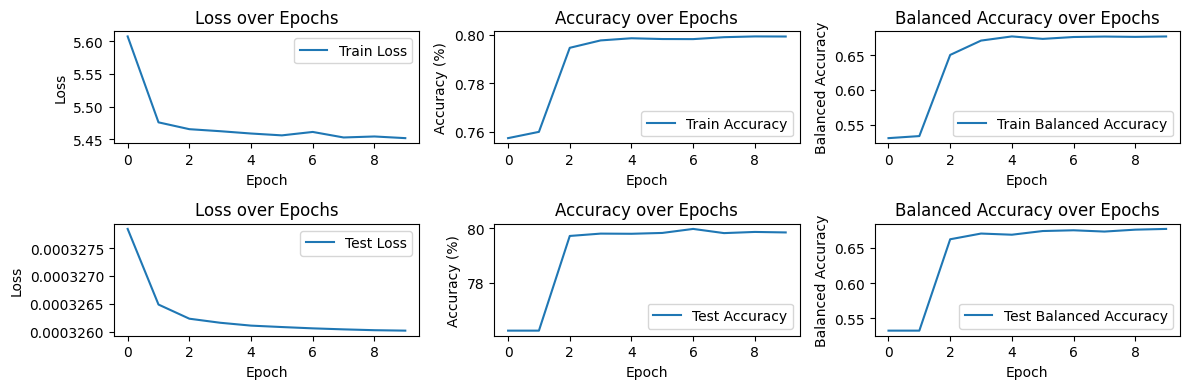

In [34]:
model = train_and_graph(train_data_basic, test_data_basic,  model_name = "Basic Neural network", input_dim=45, hidden_dims=[6,6], training_choices = {"device": "cuda", "num_workers":4, "train_batch_size": 100, "n_epochs": 10})

A good start, mini batch gradient descent works really well, I will save temporary models, and try increasing the iteration

In [35]:
torch.save(model, "Torch_Saved_NN/45x6x6x1_MiniBatch_10_Iteration.pt")

Epoch 1 Train Loss: 0.8236 Accuracy: 0.7881 Balanced Accuracy: 0.6007
Epoch: 1, Test set: Average loss: 0.0000, Accuracy: 78.64%, Balanced Accuracy: 0.62
Epoch 2 Train Loss: 0.4980 Accuracy: 0.7951 Balanced Accuracy: 0.6148
Epoch: 2, Test set: Average loss: 0.0000, Accuracy: 80.75%, Balanced Accuracy: 0.62
Epoch 3 Train Loss: 0.4258 Accuracy: 0.8067 Balanced Accuracy: 0.6429
Epoch: 3, Test set: Average loss: 0.0000, Accuracy: 84.59%, Balanced Accuracy: 0.74
Epoch 4 Train Loss: 0.3888 Accuracy: 0.8390 Balanced Accuracy: 0.7539
Epoch: 4, Test set: Average loss: 0.0000, Accuracy: 84.52%, Balanced Accuracy: 0.74
Epoch 5 Train Loss: 0.3777 Accuracy: 0.8412 Balanced Accuracy: 0.7565
Epoch: 5, Test set: Average loss: 0.0000, Accuracy: 84.85%, Balanced Accuracy: 0.77
Epoch 6 Train Loss: 0.3495 Accuracy: 0.8428 Balanced Accuracy: 0.7556
Epoch: 6, Test set: Average loss: 0.0000, Accuracy: 84.45%, Balanced Accuracy: 0.77
Epoch 7 Train Loss: 0.3498 Accuracy: 0.8432 Balanced Accuracy: 0.7568
Epoch:

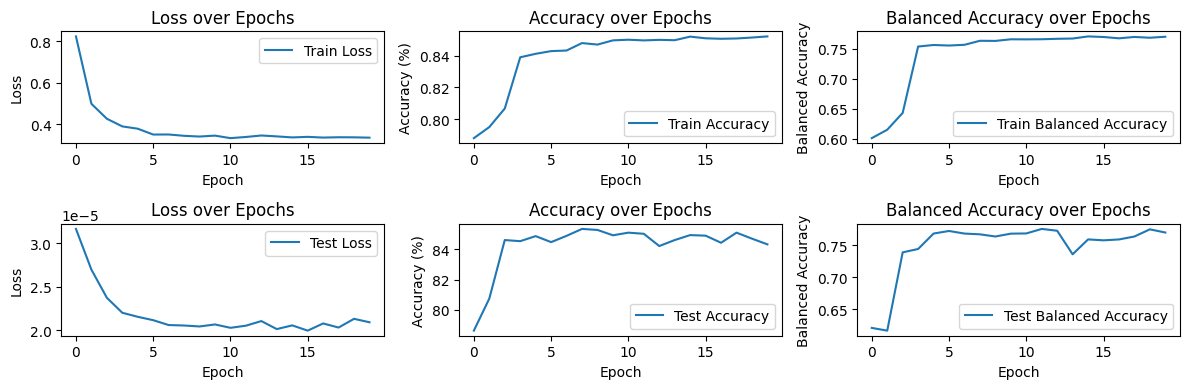

In [36]:
model = train_and_graph(train_data_basic, test_data_basic,  model_name = "Basic Neural network", input_dim=45, hidden_dims=[6,6], training_choices = {"device": "cuda", "num_workers":4, "train_batch_size": 100, "n_epochs": 20})

Even better, but now try stopping at epochs around 10, Work with different weight initialization

In [37]:
torch.save(model, "Torch_Saved_NN/45x6x6x1_MiniBatch_20_Iteration.pt")

Epoch 1 Train Loss: 1.2702 Accuracy: 0.6991 Balanced Accuracy: 0.5212
Epoch: 1, Test set: Average loss: 0.0000, Accuracy: 77.48%, Balanced Accuracy: 0.56
Epoch 2 Train Loss: 0.3934 Accuracy: 0.7901 Balanced Accuracy: 0.6101
Epoch: 2, Test set: Average loss: 0.0000, Accuracy: 79.80%, Balanced Accuracy: 0.62
Epoch 3 Train Loss: 0.3703 Accuracy: 0.8004 Balanced Accuracy: 0.6589
Epoch: 3, Test set: Average loss: 0.0000, Accuracy: 80.05%, Balanced Accuracy: 0.65
Epoch 4 Train Loss: 0.3645 Accuracy: 0.8146 Balanced Accuracy: 0.7219
Epoch: 4, Test set: Average loss: 0.0000, Accuracy: 82.78%, Balanced Accuracy: 0.77
Epoch 5 Train Loss: 0.3655 Accuracy: 0.8219 Balanced Accuracy: 0.7577
Epoch: 5, Test set: Average loss: 0.0000, Accuracy: 81.94%, Balanced Accuracy: 0.74
Epoch 6 Train Loss: 0.3590 Accuracy: 0.8234 Balanced Accuracy: 0.7609
Epoch: 6, Test set: Average loss: 0.0000, Accuracy: 81.76%, Balanced Accuracy: 0.76
Epoch 7 Train Loss: 0.3584 Accuracy: 0.8232 Balanced Accuracy: 0.7593
Epoch:

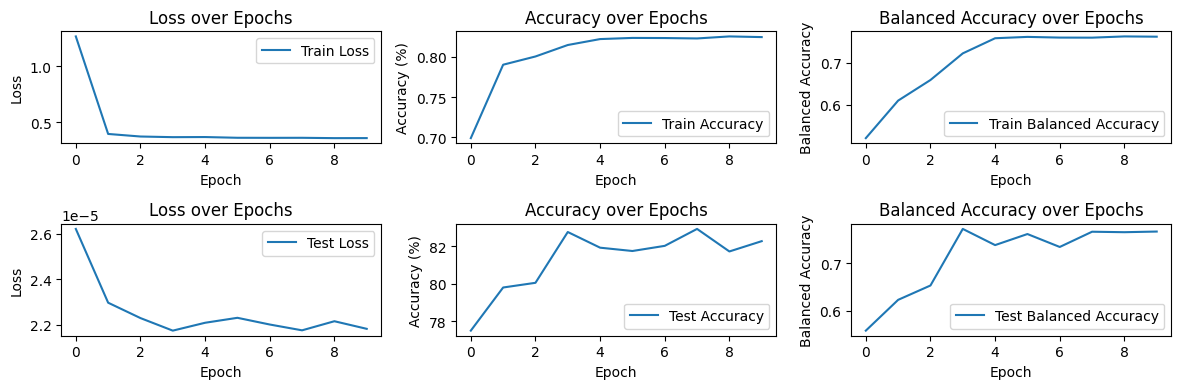

In [42]:
model = train_and_graph(train_data_basic, test_data_basic,  model_name = "Basic Neural network", input_dim=45, hidden_dims=[6,6], training_choices = {"device": "cuda", "num_workers":4, "train_batch_size": 100, "n_epochs": 10})

With NN of basic data and 47 x 6 x 6 x 1 network, Our Accuracy stays at around 82-84% for train and test, and balanced accuracy also at 76-77%. No sign of overfitting, if we set the epochs at around 10

Try making the NN more complicated

Epoch 1 Train Loss: 0.6194 Accuracy: 0.7611 Balanced Accuracy: 0.6072
Epoch: 1, Test set: Average loss: 0.0000, Accuracy: 78.51%, Balanced Accuracy: 0.62
Epoch 2 Train Loss: 0.4562 Accuracy: 0.8150 Balanced Accuracy: 0.6887
Epoch: 2, Test set: Average loss: 0.0000, Accuracy: 83.27%, Balanced Accuracy: 0.75
Epoch 3 Train Loss: 0.3571 Accuracy: 0.8355 Balanced Accuracy: 0.7567
Epoch: 3, Test set: Average loss: 0.0000, Accuracy: 83.33%, Balanced Accuracy: 0.74
Epoch 4 Train Loss: 0.3455 Accuracy: 0.8350 Balanced Accuracy: 0.7620
Epoch: 4, Test set: Average loss: 0.0000, Accuracy: 83.86%, Balanced Accuracy: 0.77


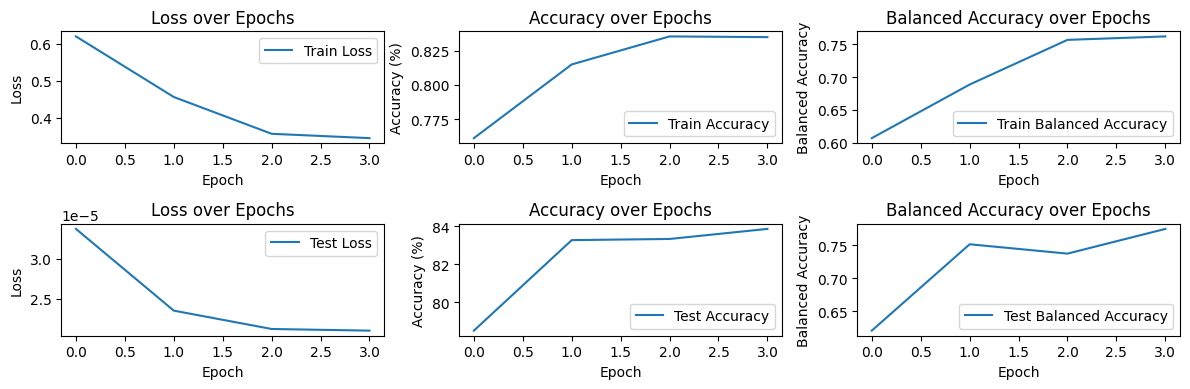

In [57]:
# Increase the size of the network, going deeper
model = train_and_graph(train_data_basic, test_data_basic,  model_name = "6x6x6_Hidden", input_dim=45, hidden_dims=[6,6,6],training_choices = {"device": "cuda", "num_workers":4, "train_batch_size": 100, "n_epochs": 4})

After 3 epochs (evaluated with Early Stopping), the accuracy stucks at 83%, which kinds of not improving. Save the model for record

In [58]:
torch.save(model, "Torch_Saved_NN/45x6x6x6x1_MiniBatch_3_Iteration.pt")

Try implementing Dropout

Epoch 1 Train Loss: 1.4092 Accuracy: 0.5574 Balanced Accuracy: 0.5052
Epoch: 1, Test set: Average loss: 0.0000, Accuracy: 76.38%, Balanced Accuracy: 0.50
Epoch 2 Train Loss: 0.4852 Accuracy: 0.7539 Balanced Accuracy: 0.5015
Epoch: 2, Test set: Average loss: 0.0000, Accuracy: 76.38%, Balanced Accuracy: 0.50
Epoch 3 Train Loss: 0.4468 Accuracy: 0.7589 Balanced Accuracy: 0.4999
Epoch: 3, Test set: Average loss: 0.0000, Accuracy: 76.38%, Balanced Accuracy: 0.50
Epoch 4 Train Loss: 0.4339 Accuracy: 0.7591 Balanced Accuracy: 0.4999
Epoch: 4, Test set: Average loss: 0.0000, Accuracy: 76.38%, Balanced Accuracy: 0.50
Epoch 5 Train Loss: 0.4313 Accuracy: 0.7591 Balanced Accuracy: 0.4999
Epoch: 5, Test set: Average loss: 0.0000, Accuracy: 76.38%, Balanced Accuracy: 0.50
Epoch 6 Train Loss: 0.4238 Accuracy: 0.7592 Balanced Accuracy: 0.5000
Epoch: 6, Test set: Average loss: 0.0000, Accuracy: 76.38%, Balanced Accuracy: 0.50


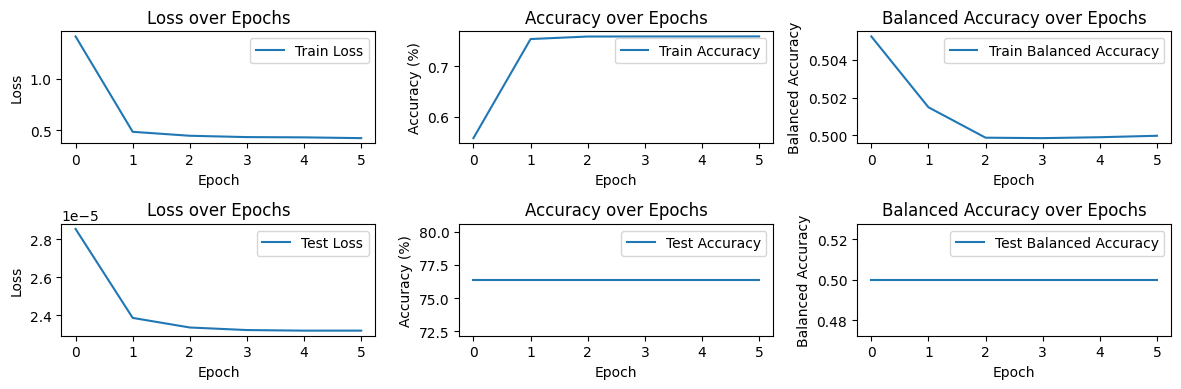

BinaryClassificationModel(
  (fc): ModuleList(
    (0): Linear(in_features=45, out_features=6, bias=True)
    (1-2): 2 x Linear(in_features=6, out_features=6, bias=True)
    (3): Linear(in_features=6, out_features=1, bias=True)
  )
  (dropout): ModuleList(
    (0-2): 3 x Dropout(p=0.4, inplace=False)
  )
)

In [59]:
# Increase the size of the network, going deeper
train_and_graph(train_data_basic, test_data_basic,  model_name = "6x6x6_Hidden", input_dim=45, hidden_dims=[6,6,6],training_choices = {"device": "cuda", "num_workers":4, "train_batch_size": 100, "n_epochs": 6}, dropout = [0.4, 0.4, 0.4])

Dropout doesn't help. Still use 3 layers, but smaller network

Epoch 1 Train Loss: 0.5834 Accuracy: 0.7914 Balanced Accuracy: 0.6209
Epoch: 1, Test set: Average loss: 0.0000, Accuracy: 79.62%, Balanced Accuracy: 0.63
Epoch 2 Train Loss: 0.5107 Accuracy: 0.8044 Balanced Accuracy: 0.6422
Epoch: 2, Test set: Average loss: 0.0000, Accuracy: 82.85%, Balanced Accuracy: 0.70
Epoch 3 Train Loss: 0.4590 Accuracy: 0.8367 Balanced Accuracy: 0.7411
Epoch: 3, Test set: Average loss: 0.0000, Accuracy: 83.08%, Balanced Accuracy: 0.73
Epoch 4 Train Loss: 0.4265 Accuracy: 0.8410 Balanced Accuracy: 0.7524
Epoch: 4, Test set: Average loss: 0.0000, Accuracy: 83.69%, Balanced Accuracy: 0.76
Epoch 5 Train Loss: 0.4055 Accuracy: 0.8441 Balanced Accuracy: 0.7604
Epoch: 5, Test set: Average loss: 0.0000, Accuracy: 83.94%, Balanced Accuracy: 0.73
Epoch 6 Train Loss: 0.3927 Accuracy: 0.8441 Balanced Accuracy: 0.7556
Epoch: 6, Test set: Average loss: 0.0000, Accuracy: 84.77%, Balanced Accuracy: 0.76


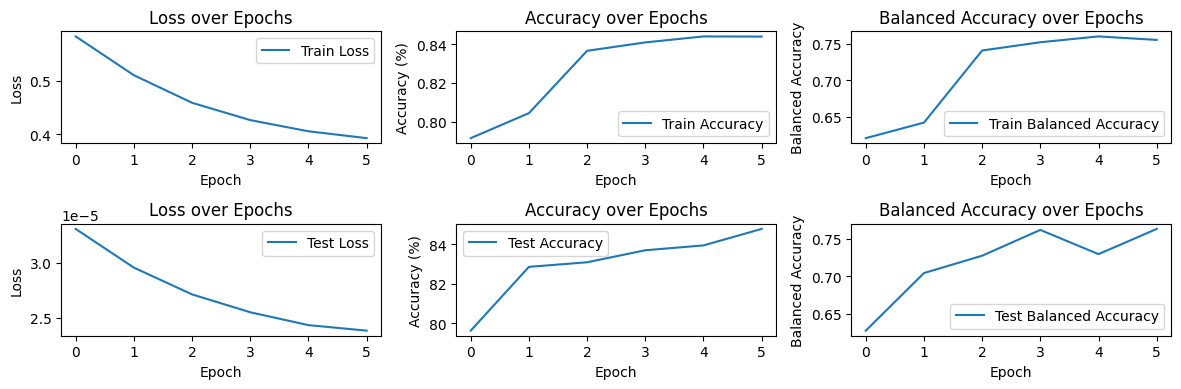

In [62]:
# Increase the size of the network, going deeper
model = train_and_graph(train_data_basic, test_data_basic,  model_name = "6x6x6_Hidden", input_dim=45, hidden_dims=[5,5,2],training_choices = {"device": "cuda", "num_workers":4, "train_batch_size": 100, "n_epochs": 6})

They work quite good, save it for record

In [63]:
torch.save(model, "Torch_Saved_NN/45x5x5x2x1_MiniBatch_6_Iteration.pt")

Three layers work quite well, similar to that of two layers. Now, try using three layers where using Weighted_BCE to increase the balanced_accuracy

Count_neg:  24720
Count_pos:  7841
Epoch 1 Train Loss: 0.7377 Accuracy: 0.7593 Balanced Accuracy: 0.5000
Epoch: 1, Test set: Average loss: 0.0000, Accuracy: 76.38%, Balanced Accuracy: 0.50
Epoch 2 Train Loss: 0.6577 Accuracy: 0.7591 Balanced Accuracy: 0.5000
Epoch: 2, Test set: Average loss: 0.0000, Accuracy: 76.38%, Balanced Accuracy: 0.50
Epoch 3 Train Loss: 0.6529 Accuracy: 0.7591 Balanced Accuracy: 0.5000
Epoch: 3, Test set: Average loss: 0.0000, Accuracy: 76.38%, Balanced Accuracy: 0.50
Epoch 4 Train Loss: 0.6527 Accuracy: 0.7592 Balanced Accuracy: 0.5000
Epoch: 4, Test set: Average loss: 0.0000, Accuracy: 76.38%, Balanced Accuracy: 0.50
Epoch 5 Train Loss: 0.6527 Accuracy: 0.7593 Balanced Accuracy: 0.5000
Epoch: 5, Test set: Average loss: 0.0000, Accuracy: 76.38%, Balanced Accuracy: 0.50
Epoch 6 Train Loss: 0.6526 Accuracy: 0.7592 Balanced Accuracy: 0.5000
Epoch: 6, Test set: Average loss: 0.0000, Accuracy: 76.38%, Balanced Accuracy: 0.50


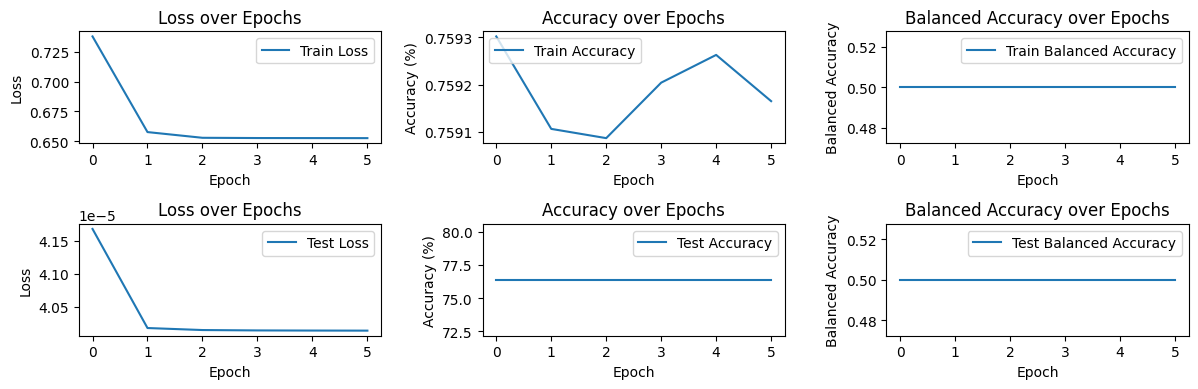

In [64]:
model = train_and_graph(train_data_basic, test_data_basic,  model_name = "5x5x2_Hidden with Weighted_BCE", input_dim=45, hidden_dims=[5,5,2], training_choices={"criterion": "Weighted_BCE", "device": "cuda", "num_workers":4, "train_batch_size": 100, "n_epochs": 6})

Using Weighted BCE is actually bad: As the Accuracy now falls to 76%, and the balanced accuracy does not improve much either, now I will use SMOTE to experiment

Epoch 1 Train Loss: 0.6021 Accuracy: 0.6617 Balanced Accuracy: 0.6608
Epoch: 1, Test set: Average loss: 0.0000, Accuracy: 74.55%, Balanced Accuracy: 0.72
Epoch 2 Train Loss: 0.4385 Accuracy: 0.8111 Balanced Accuracy: 0.8108
Epoch: 2, Test set: Average loss: 0.0000, Accuracy: 77.41%, Balanced Accuracy: 0.81
Epoch 3 Train Loss: 0.4290 Accuracy: 0.7830 Balanced Accuracy: 0.7830
Epoch: 3, Test set: Average loss: 0.0000, Accuracy: 78.20%, Balanced Accuracy: 0.77
Epoch 4 Train Loss: 0.4150 Accuracy: 0.7929 Balanced Accuracy: 0.7927
Epoch: 4, Test set: Average loss: 0.0000, Accuracy: 77.15%, Balanced Accuracy: 0.81
Epoch 5 Train Loss: 0.4101 Accuracy: 0.7884 Balanced Accuracy: 0.7881
Epoch: 5, Test set: Average loss: 0.0000, Accuracy: 77.85%, Balanced Accuracy: 0.77
Epoch 6 Train Loss: 0.4002 Accuracy: 0.7884 Balanced Accuracy: 0.7884
Epoch: 6, Test set: Average loss: 0.0000, Accuracy: 78.33%, Balanced Accuracy: 0.77
Epoch 7 Train Loss: 0.4032 Accuracy: 0.8028 Balanced Accuracy: 0.8030
Epoch:

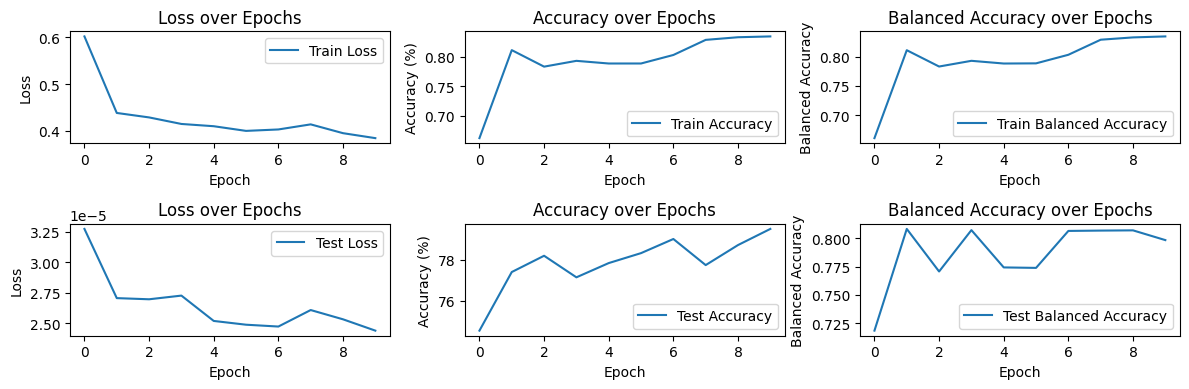

In [66]:
model = train_and_graph(train_data_smote, test_data_smote,  model_name = "6x6_Hidden_With_SMOTE", input_dim=45, hidden_dims=[5,5,2], training_choices={"device": "cuda", "num_workers":4, "train_batch_size": 100, "n_epochs": 10})

At the expense of decreasing accuracy to 79%, we increase the balanced accuracy to around 80-81%

In [67]:
#Balanced Accuracy Increase greatly, saving the model
torch.save(model, "Torch_Saved_NN/45x5x5x2x1_MiniBatch_10_Iteration_With_SMOTE.pt")

Still doesn't help, try the one in lecture: "Make the layer narrow but with deeper"

Epoch 1 Train Loss: 0.6459 Accuracy: 0.6257 Balanced Accuracy: 0.6268
Epoch: 1, Test set: Average loss: 0.0000, Accuracy: 77.42%, Balanced Accuracy: 0.79
Epoch 2 Train Loss: 0.4564 Accuracy: 0.8060 Balanced Accuracy: 0.8058
Epoch: 2, Test set: Average loss: 0.0000, Accuracy: 75.74%, Balanced Accuracy: 0.80
Epoch 3 Train Loss: 0.4353 Accuracy: 0.8078 Balanced Accuracy: 0.8078
Epoch: 3, Test set: Average loss: 0.0000, Accuracy: 75.79%, Balanced Accuracy: 0.80
Epoch 4 Train Loss: 0.4285 Accuracy: 0.8092 Balanced Accuracy: 0.8092
Epoch: 4, Test set: Average loss: 0.0000, Accuracy: 76.41%, Balanced Accuracy: 0.80
Epoch 5 Train Loss: 0.4259 Accuracy: 0.8093 Balanced Accuracy: 0.8090
Epoch: 5, Test set: Average loss: 0.0000, Accuracy: 76.53%, Balanced Accuracy: 0.80
Epoch 6 Train Loss: 0.4239 Accuracy: 0.8092 Balanced Accuracy: 0.8093
Epoch: 6, Test set: Average loss: 0.0000, Accuracy: 76.84%, Balanced Accuracy: 0.80
Epoch 7 Train Loss: 0.4221 Accuracy: 0.8105 Balanced Accuracy: 0.8106
Epoch:

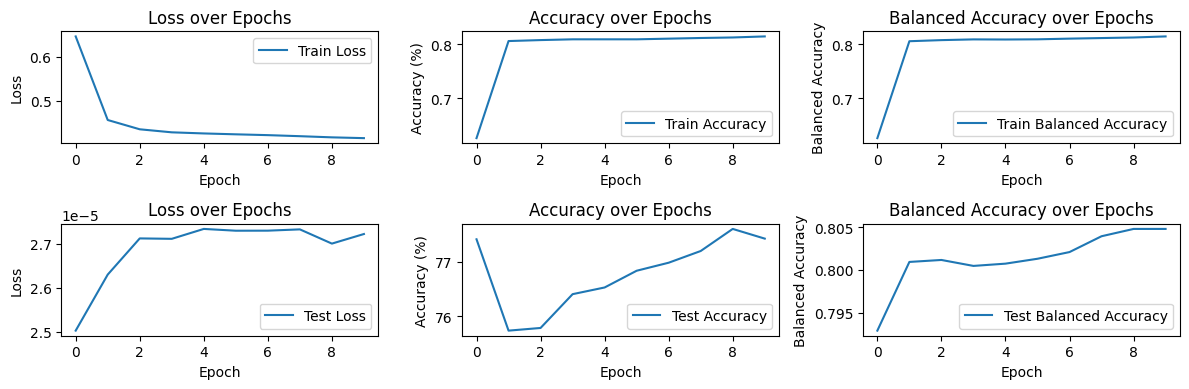

In [68]:
model = train_and_graph(train_data_smote, test_data_smote,  model_name = "Narrow_But_Deeper", input_dim=45, hidden_dims=[6,3,3,3,2], training_choices={"device": "cuda", "num_workers":4, "train_batch_size": 100, "n_epochs": 10})

In [69]:
#Balanced Accuracy Increase greatly, saving the model
torch.save(model, "Torch_Saved_NN/45x6x3x3x3x2x1_MiniBatch_10_Iteration_With_SMOTE.pt")

Try the same with regular data

Epoch 1 Train Loss: 0.6419 Accuracy: 0.7591 Balanced Accuracy: 0.5000
Epoch: 1, Test set: Average loss: 0.0000, Accuracy: 76.38%, Balanced Accuracy: 0.50
Epoch 2 Train Loss: 0.5747 Accuracy: 0.7592 Balanced Accuracy: 0.5000
Epoch: 2, Test set: Average loss: 0.0000, Accuracy: 76.38%, Balanced Accuracy: 0.50
Epoch 3 Train Loss: 0.5532 Accuracy: 0.7591 Balanced Accuracy: 0.5000
Epoch: 3, Test set: Average loss: 0.0000, Accuracy: 76.38%, Balanced Accuracy: 0.50
Epoch 4 Train Loss: 0.5520 Accuracy: 0.7592 Balanced Accuracy: 0.5000
Epoch: 4, Test set: Average loss: 0.0000, Accuracy: 76.38%, Balanced Accuracy: 0.50
Epoch 5 Train Loss: 0.5521 Accuracy: 0.7591 Balanced Accuracy: 0.5000
Epoch: 5, Test set: Average loss: 0.0000, Accuracy: 76.38%, Balanced Accuracy: 0.50
Epoch 6 Train Loss: 0.5520 Accuracy: 0.7592 Balanced Accuracy: 0.5000
Epoch: 6, Test set: Average loss: 0.0000, Accuracy: 76.38%, Balanced Accuracy: 0.50
Epoch 7 Train Loss: 0.5521 Accuracy: 0.7591 Balanced Accuracy: 0.5000
Epoch:

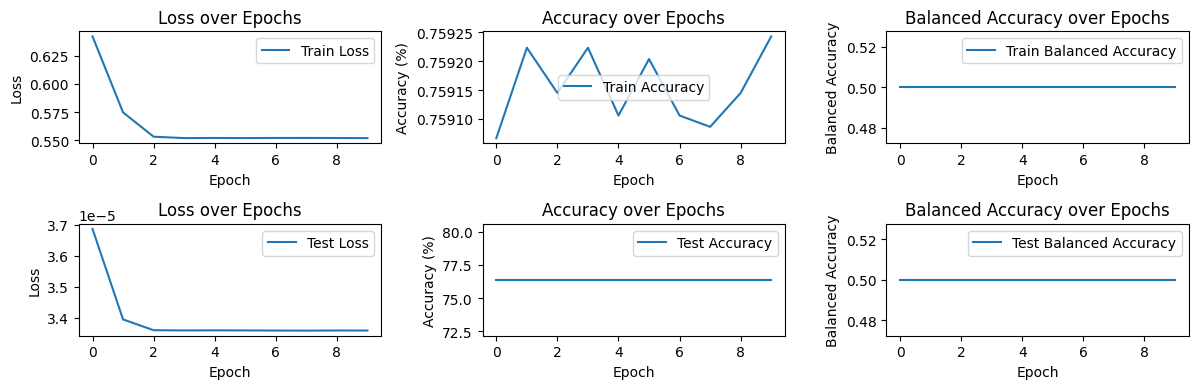

In [70]:
model = train_and_graph(train_data_basic, test_data_basic,  model_name = "Narrow_But_Deeper", input_dim=45, hidden_dims=[6,3,3,3,2], training_choices={"device": "cuda", "num_workers":4, "train_batch_size": 100, "n_epochs": 10})

Accuracy tends to stuck.

# Final Model

Pick one of the best model: 5x5x2 for Accuracy

In [71]:
model_filename = "Torch_Saved_NN/45x5x5x2x1_MiniBatch_6_Iteration.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = 4
model = torch.load(model_filename)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())
train_loader, test_loader = create_dataloaders(train_data_basic, test_data_basic, train_batch_size=None, num_workers=num_workers)

# Metrics storage
train_epoch_losses = []
train_epoch_accuracies = []
train_epoch_balanced_accuracies = []
test_epoch_losses = []
test_epoch_accuracies = []
test_epoch_balanced_accuracies = []

#Train mode
model.eval()
running_loss = 0.0
running_accuracy = 0.0
running_balanced_accuracy = 0.0
total_batches = 0

for data, target in train_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = criterion(output, target.view_as(output))
    
    # Convert output probabilities to binary predictions (0 or 1)
    preds = output > 0.5
    
    # Update running loss and accuracy
    running_loss += loss.item()
    running_accuracy += compute_accuracy(target, preds)
    running_balanced_accuracy += compute_balanced_accuracy(target, preds)
    total_batches += 1
    
# Calculate the average loss and accuracy over the epoch
epoch_loss = running_loss / total_batches
epoch_accuracy = running_accuracy / total_batches
epoch_balanced_accuracy = running_balanced_accuracy / total_batches

train_epoch_losses.append(epoch_loss)
train_epoch_accuracies.append(epoch_accuracy)
train_epoch_balanced_accuracies.append(epoch_balanced_accuracy)
    
# Validation phase
model.eval()
test_loss = 0
correct = 0
all_outputs = []
all_targets = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.round()  # Round predictions to the closest integer
        correct += pred.eq(target.view_as(pred)).sum().item()
        all_outputs.append(output)
        all_targets.append(target)

# Calculate total test loss
test_loss /= len(test_loader.dataset)
test_epoch_losses.append(test_loss)

# Calculate accuracy
accuracy = 100. * correct / len(test_loader.dataset)
test_epoch_accuracies.append(accuracy)

# Calculate balanced accuracy
all_outputs = torch.cat(all_outputs)
all_targets = torch.cat(all_targets)
balanced_acc = compute_balanced_accuracy(all_targets, all_outputs)
test_epoch_balanced_accuracies.append(balanced_acc)
print(f'Train set: Average loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy*100:.2f}%, Balanced Accuracy: {epoch_balanced_accuracy*100:.2f}')
print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%, Balanced Accuracy: {balanced_acc:.2f}')

Train set: Average loss: 0.3883, Accuracy: 85.00%, Balanced Accuracy: 76.77
Test set: Average loss: 0.0000, Accuracy: 84.77%, Balanced Accuracy: 0.76


Implements the Cross Validation

In [77]:
n_splits = 10
hidden_dims = [5,5,2]
n_epochs = 6
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Convert dataframe to tensor
X = torch.tensor(train_data_basic.drop('income', axis=1).values).float()
y = torch.tensor(train_data_basic['income'].values).float()

# Store metrics for each fold
fold_test_accuracies = []
fold_test_balanced_accuracies = []

for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    print(f'Fold {fold+1}/{10}')

    # Split the data into training and test sets for the current fold
    train_X, test_X = X[train_index], X[test_index]
    train_y, test_y = y[train_index], y[test_index]

    # Create custom datasets for DataLoader
    train_dataset = torch.utils.data.TensorDataset(train_X, train_y)
    test_dataset = torch.utils.data.TensorDataset(test_X, test_y)

    # Instantiate the model, criterion, and optimizer as before
    model = BinaryClassificationModel(input_dim=45, hidden_dims=hidden_dims, dropout=None).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())


    # Create dataloaders for the fold
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

    # Training loop
    for epoch in range(n_epochs):
        print(f'Fold {fold+1}/{10}, epoch: {epoch+1}/{n_epochs}')
        model.train()

        running_loss = 0.0
        running_accuracy = 0.0
        running_balanced_accuracy = 0.0
        total_batches = 0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.view_as(output))
            loss.backward()
            optimizer.step()

  
    # Validation phase
    model.eval()
    test_loss = 0
    correct = 0
    all_outputs = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(torch.squeeze(output), target).item()
            pred = output.round()  # Round predictions to the closest integer
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_outputs.append(output)
            all_targets.append(target)
    
    # Calculate accuracy
    accuracy = 100. * correct / len(test_loader.dataset)
    fold_test_accuracies.append(accuracy)
    
    # Calculate balanced accuracy
    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)
    balanced_acc = compute_balanced_accuracy(all_targets, all_outputs)
    fold_test_balanced_accuracies.append(balanced_acc)
    print("Current fold accuracy and balanced accuracy: ", accuracy, balanced_acc)

# Calculate average metrics across folds
avg_test_accuracy = np.mean(fold_test_accuracies)
avg_test_balanced_accuracy = np.mean(fold_test_balanced_accuracies)
print(f'Average Test Accuracy: {avg_test_accuracy:.4f}')
print(f'Average Test Balanced Accuracy: {avg_test_balanced_accuracy:.4f}')


Fold 1/10
Fold 1/10, epoch: 1/6
Fold 1/10, epoch: 2/6
Fold 1/10, epoch: 3/6
Fold 1/10, epoch: 4/6
Fold 1/10, epoch: 5/6
Fold 1/10, epoch: 6/6
Current fold accuracy and balanced accuracy:  81.6702486951182 0.7258064848597283
Fold 2/10
Fold 2/10, epoch: 1/6
Fold 2/10, epoch: 2/6
Fold 2/10, epoch: 3/6
Fold 2/10, epoch: 4/6
Fold 2/10, epoch: 5/6
Fold 2/10, epoch: 6/6
Current fold accuracy and balanced accuracy:  81.81818181818181 0.7378537580080575
Fold 3/10
Fold 3/10, epoch: 1/6
Fold 3/10, epoch: 2/6
Fold 3/10, epoch: 3/6
Fold 3/10, epoch: 4/6
Fold 3/10, epoch: 5/6
Fold 3/10, epoch: 6/6
Current fold accuracy and balanced accuracy:  82.15601965601965 0.7601112046760452
Fold 4/10
Fold 4/10, epoch: 1/6
Fold 4/10, epoch: 2/6
Fold 4/10, epoch: 3/6
Fold 4/10, epoch: 4/6
Fold 4/10, epoch: 5/6
Fold 4/10, epoch: 6/6
Current fold accuracy and balanced accuracy:  75.92137592137593 0.5
Fold 5/10
Fold 5/10, epoch: 1/6
Fold 5/10, epoch: 2/6
Fold 5/10, epoch: 3/6
Fold 5/10, epoch: 4/6
Fold 5/10, epoch: 

Print weights

In [84]:
model = torch.load("Torch_Saved_NN/45x5x5x2x1_MiniBatch_6_Iteration.pt")

# Move model to CPU for inspection
model = model.to('cpu')

# Print the weights of each layer
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.0.weight tensor([[-0.1569, -0.0426, -0.4258,  0.0100, -0.0406, -0.1249,  0.0156,  0.2466,
         -0.0076,  0.2979,  0.0704,  0.4858,  0.4204,  0.3558, -0.1027, -0.3058,
          0.3821,  0.2780,  0.0466,  0.1793,  0.0311,  0.0940, -0.1992,  0.7389,
          0.5334,  0.2804,  0.5181,  0.5284,  0.1721, -0.1753, -0.1145, -0.3440,
          0.2355,  0.5807,  0.5534,  0.5743,  0.7272, -0.3258,  0.2427,  0.0146,
          0.1752,  0.1562,  0.0764,  0.2660,  0.2632],
        [ 0.3798,  0.0727,  0.7750,  0.4728, -0.1323, -0.1230,  0.2294,  0.1703,
          0.0229,  0.2385,  0.2929, -0.3659,  0.0408, -0.2927,  0.0353,  0.8881,
         -0.1679, -0.1882, -0.1141, -0.1050, -0.0524,  0.1247,  0.6850, -0.5052,
         -0.4084, -0.1110, -0.4564, -0.3112,  0.3949,  0.1661,  0.2645,  0.3245,
         -0.2573, -0.2387, -0.4138, -0.5741, -0.5481,  0.6020,  0.1190,  0.1318,
          0.3760,  0.0581,  0.0525, -0.1082,  0.4433],
        [ 0.0319,  0.0203,  0.0429, -0.1068, -0.0608, -0.1000, -0.03

Pick one of the best model and implement Cross Validation: 5x5x2 6 iteration for Balanced Accuracy

In [78]:
model_filename = "Torch_Saved_NN/45x5x5x2x1_MiniBatch_10_Iteration_With_SMOTE.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = 4
model = torch.load(model_filename)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())
train_loader, test_loader = create_dataloaders(train_data_smote, test_data_smote, train_batch_size=None, num_workers=num_workers)

# Metrics storage
train_epoch_losses = []
train_epoch_accuracies = []
train_epoch_balanced_accuracies = []
test_epoch_losses = []
test_epoch_accuracies = []
test_epoch_balanced_accuracies = []

#Train mode
model.eval()
running_loss = 0.0
running_accuracy = 0.0
running_balanced_accuracy = 0.0
total_batches = 0

for data, target in train_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = criterion(output, target.view_as(output))
    
    # Convert output probabilities to binary predictions (0 or 1)
    preds = output > 0.5
    
    # Update running loss and accuracy
    running_loss += loss.item()
    running_accuracy += compute_accuracy(target, preds)
    running_balanced_accuracy += compute_balanced_accuracy(target, preds)
    total_batches += 1
    
# Calculate the average loss and accuracy over the epoch
epoch_loss = running_loss / total_batches
epoch_accuracy = running_accuracy / total_batches
epoch_balanced_accuracy = running_balanced_accuracy / total_batches

train_epoch_losses.append(epoch_loss)
train_epoch_accuracies.append(epoch_accuracy)
train_epoch_balanced_accuracies.append(epoch_balanced_accuracy)
    
# Validation phase
model.eval()
test_loss = 0
correct = 0
all_outputs = []
all_targets = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.round()  # Round predictions to the closest integer
        correct += pred.eq(target.view_as(pred)).sum().item()
        all_outputs.append(output)
        all_targets.append(target)

# Calculate total test loss
test_loss /= len(test_loader.dataset)
test_epoch_losses.append(test_loss)

# Calculate accuracy
accuracy = 100. * correct / len(test_loader.dataset)
test_epoch_accuracies.append(accuracy)

# Calculate balanced accuracy
all_outputs = torch.cat(all_outputs)
all_targets = torch.cat(all_targets)
balanced_acc = compute_balanced_accuracy(all_targets, all_outputs)
test_epoch_balanced_accuracies.append(balanced_acc)
print(f'Train set: Average loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy*100:.2f}%, Balanced Accuracy: {epoch_balanced_accuracy*100:.2f}')
print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%, Balanced Accuracy: {balanced_acc:.2f}')

Train set: Average loss: 0.3665, Accuracy: 83.47%, Balanced Accuracy: 83.47
Test set: Average loss: 0.0000, Accuracy: 79.51%, Balanced Accuracy: 0.80


In [79]:
n_splits = 10
hidden_dims = [5,5,2]
n_epochs = 10
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Convert dataframe to tensor
X = torch.tensor(train_data_smote.drop('income', axis=1).values).float()
y = torch.tensor(train_data_smote['income'].values).float()

# Store metrics for each fold
fold_test_accuracies = []
fold_test_balanced_accuracies = []

for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    print(f'Fold {fold+1}/{10}')

    # Split the data into training and test sets for the current fold
    train_X, test_X = X[train_index], X[test_index]
    train_y, test_y = y[train_index], y[test_index]

    # Create custom datasets for DataLoader
    train_dataset = torch.utils.data.TensorDataset(train_X, train_y)
    test_dataset = torch.utils.data.TensorDataset(test_X, test_y)

    # Instantiate the model, criterion, and optimizer as before
    model = BinaryClassificationModel(input_dim=45, hidden_dims=hidden_dims, dropout=None).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())


    # Create dataloaders for the fold
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

    # Training loop
    for epoch in range(n_epochs):
        print(f'Fold {fold+1}/{10}, epoch: {epoch+1}/{n_epochs}')
        model.train()

        running_loss = 0.0
        running_accuracy = 0.0
        running_balanced_accuracy = 0.0
        total_batches = 0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.view_as(output))
            loss.backward()
            optimizer.step()

  
    # Validation phase
    model.eval()
    test_loss = 0
    correct = 0
    all_outputs = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(torch.squeeze(output), target).item()
            pred = output.round()  # Round predictions to the closest integer
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_outputs.append(output)
            all_targets.append(target)
    
    # Calculate accuracy
    accuracy = 100. * correct / len(test_loader.dataset)
    fold_test_accuracies.append(accuracy)
    
    # Calculate balanced accuracy
    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)
    balanced_acc = compute_balanced_accuracy(all_targets, all_outputs)
    fold_test_balanced_accuracies.append(balanced_acc)
    print("Current fold accuracy and balanced accuracy: ", accuracy, balanced_acc)

# Calculate average metrics across folds
avg_test_accuracy = np.mean(fold_test_accuracies)
avg_test_balanced_accuracy = np.mean(fold_test_balanced_accuracies)
print(f'Average Test Accuracy: {avg_test_accuracy:.4f}')
print(f'Average Test Balanced Accuracy: {avg_test_balanced_accuracy:.4f}')


Fold 1/10
Fold 1/10, epoch: 1/10
Fold 1/10, epoch: 2/10
Fold 1/10, epoch: 3/10
Fold 1/10, epoch: 4/10
Fold 1/10, epoch: 5/10
Fold 1/10, epoch: 6/10
Fold 1/10, epoch: 7/10
Fold 1/10, epoch: 8/10
Fold 1/10, epoch: 9/10
Fold 1/10, epoch: 10/10
Current fold accuracy and balanced accuracy:  81.02750809061489 0.8102750809061489
Fold 2/10
Fold 2/10, epoch: 1/10
Fold 2/10, epoch: 2/10
Fold 2/10, epoch: 3/10
Fold 2/10, epoch: 4/10
Fold 2/10, epoch: 5/10
Fold 2/10, epoch: 6/10
Fold 2/10, epoch: 7/10
Fold 2/10, epoch: 8/10
Fold 2/10, epoch: 9/10
Fold 2/10, epoch: 10/10
Current fold accuracy and balanced accuracy:  83.8794498381877 0.838794498381877
Fold 3/10
Fold 3/10, epoch: 1/10
Fold 3/10, epoch: 2/10
Fold 3/10, epoch: 3/10
Fold 3/10, epoch: 4/10
Fold 3/10, epoch: 5/10
Fold 3/10, epoch: 6/10
Fold 3/10, epoch: 7/10
Fold 3/10, epoch: 8/10
Fold 3/10, epoch: 9/10
Fold 3/10, epoch: 10/10
Current fold accuracy and balanced accuracy:  78.25647249190939 0.7825647249190939
Fold 4/10
Fold 4/10, epoch: 1/

In [85]:
model = torch.load("Torch_Saved_NN/45x5x5x2x1_MiniBatch_10_Iteration_With_SMOTE.pt")

# Move model to CPU for inspection
model = model.to('cpu')

# Print the weights of each layer
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.0.weight tensor([[-0.2600,  0.0240,  0.2388,  0.1206, -0.1121,  0.0924,  0.0869,  0.0594,
         -0.0644,  0.1805,  0.1864, -0.1521,  0.0931, -0.3872,  0.3351,  0.6817,
         -0.1372,  0.1337, -0.1533, -0.0118, -0.3685,  0.0579,  0.4022, -0.2505,
         -0.1218, -0.0040, -0.1169, -0.5326,  0.2448,  0.2729,  0.2191,  0.2445,
          0.0764, -0.2883, -0.3304,  0.1564, -0.2634,  0.2075,  0.2518,  0.2593,
          0.5479,  0.2813,  0.1865,  0.1433,  0.4963],
        [-0.9585, -0.0369,  0.0450,  0.0567,  0.1157,  0.0542,  0.1246,  0.5051,
          0.2314, -0.0167,  0.2230,  0.1153,  0.1903,  0.1507, -0.3312, -0.0672,
          0.0116, -0.1088, -0.1644, -0.3382,  0.1712,  0.0193,  0.1973,  0.0032,
          0.0367, -0.0841, -0.2469,  0.4992,  0.0480, -0.6319,  0.0127,  0.4805,
          0.2257, -0.0566,  0.2794,  0.3515,  0.1250,  0.2112, -0.2915, -0.0417,
          0.0573,  0.2040, -0.0694,  0.1043, -0.0412],
        [-0.4153, -0.0080, -0.0329,  0.1504, -0.0208,  0.1403, -0.38